In [1]:
import numpy as np

n_cls = 20 # Number of samples in each class.
np.random.seed(1) # for reproducibility
x11 = np.random.normal(0.5, 1, (n_cls, 1))
np.random.seed(2) # for reproducibility
x12 = np.random.normal(0.4, 1, (n_cls, 1))
np.random.seed(3) # for reproducibility
x21 = np.random.normal(-0.3, 1, (n_cls, 1))
np.random.seed(4) # for reproducibility
x22 = np.random.normal(-0.5, 1, (n_cls, 1))
X = np.vstack((
np.hstack((x11, x12)),
np.hstack((x21, x22))
))
y = np.hstack((-1 * np.ones(n_cls), +1 * np.ones(n_cls)))

In [2]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1000, random_state=1, probability=True)
clf.fit(X, y)

SVC(C=1000, kernel='linear', probability=True, random_state=1)

Text(0, 0.5, 'x2')

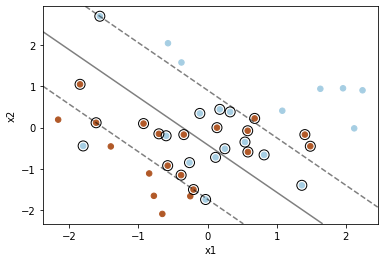

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')

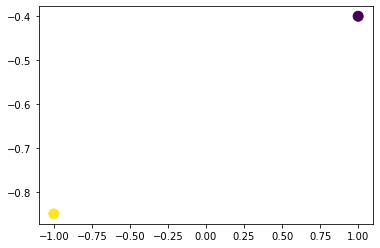

In [4]:
X_new = np.array([
[1, -0.4],
[-1, -0.85],
])
y_new = clf.predict(X_new)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100)
fig.canvas.draw()
fig.canvas.flush_events()

In [6]:
#Exercise 2

import csv
from typing import Dict

def get_vocabulary_dict() -> Dict[int, str]:
    vocabularyDict = dict()
    vocab = open("data\\vocab.txt", 'r')
    lines = vocab.readlines()
    for line in lines:
        elements = line.split()
        vocabularyDict[int(elements[0])] = elements[1]
    return vocabularyDict

In [8]:
import re
from typing import List
from nltk import PorterStemmer

def process_email(email_contents: str) -> List[int]:
    vocabulary_dict = get_vocabulary_dict()
    word_indices = []
    header_token = '\n\n'
    header_start = email_contents.find(header_token)
    email_contents = email_contents[header_start+len(header_token):]
    email_contents = email_contents.lower()
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)
    email_contents = re.sub('\d+', 'number', email_contents)
    email_contents = re.sub('http[s]?:\/\/[a-zA-Z-9\.\/-]+', 'httpaddr', email_contents)
    email_contents = re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', 'emailaddr', email_contents)
    email_contents = re.sub('\$+', 'dollar', email_contents)
    col = 0
    tokens = re.split('[ @$/#.-:&*\+=\[\]?!\(\)\{\},''">_<;#\n\r]', email_contents)
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]', '', token)
        token = PorterStemmer().stem(token.strip())
        if len(token) < 1:
            continue
        for key in vocabulary_dict.keys():
            if vocabulary_dict[key] == token:
                word_indices.append(key)
    return word_indices

In [9]:
from typing import List

def email_features(word_indices: List[int]) -> np.ndarray:
    n_words = 1899
    result = np.zeros([1, n_words])
    for i in range(n_words):
        if i in word_indices:
            result[0, i - 1] = 1
    return result

In [10]:
from sklearn import svm
from sklearn.metrics import accuracy_score

def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        result = str(file.readlines()).replace('\n', '')
    return result

In [11]:
print('\nPreprocessing sample email (emailSample1.txt)\n')

file_contents = read_file('data/emailSample1.txt')
word_indices = process_email(file_contents)

print('Word Indices: \n')
print(word_indices)
print('\n\n')


Preprocessing sample email (emailSample1.txt)

Word Indices: 

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1895, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699]





In [14]:
print('\nExtracting features from sample email (emailSample1.txt)\n')

file_contents = read_file('data/emailSample1.txt')
word_indices = process_email(file_contents)
features = email_features(word_indices)

print('Length of feature vector: {}\n'.format(len(features[0])))
print('Number of non-zero entries: {}\n'.format(sum(sum(features > 0))))


Extracting features from sample email (emailSample1.txt)

Length of feature vector: 1899

Number of non-zero entries: 43



In [15]:
print('\nLoading the training dataset...')
X_train = np.genfromtxt('data/spamTrain_X.csv', delimiter=',')
y_train = np.genfromtxt('data/spamTrain_y.csv', delimiter=',')
print('The training dataset was loaded.')

print('\nTraining Linear SVM (Spam Classification)\n')
print('(this may take 1 to 2 minutes) ...\n')

clf = svm.SVC(kernel = 'linear', C = 0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred)
print('Training Accuracy: {:.2f}%\n'.format(acc_train * 100))


Loading the training dataset...
The training dataset was loaded.

Training Linear SVM (Spam Classification)

(this may take 1 to 2 minutes) ...

Training Accuracy: 99.83%



In [16]:
X_test = np.genfromtxt('data/spamTest_X.csv', delimiter=',')
y_test = np.genfromtxt('data/spamTest_y.csv', delimiter=',')

print('\nEvaluating the trained Linear SVM on a test set ...\n')

y_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print('Test Accuracy: {:.2f}%\n'.format(acc_test * 100))


Evaluating the trained Linear SVM on a test set ...

Test Accuracy: 98.90%



In [17]:
weights = clf.coef_
idx = np.flip(np.argsort(weights)).astype(int)

vocabulary_dict = get_vocabulary_dict()

print('\nTop predictors of spam: \n')
for i in range(15):
    print(' {word:<20}: {weight:10.6f}'.format(
        word=list(vocabulary_dict.values())[idx[0,i]], 
        weight=weights[0,i]))
print('\n\n')


Top predictors of spam: 

 our                 :   0.007932
 click               :   0.015633
 remov               :   0.055465
 guarante            :  -0.013416
 visit               :  -0.066198
 basenumb            :   0.036595
 dollar              :   0.183376
 will                :  -0.024886
 price               :  -0.021608
 pleas               :   0.020790
 most                :   0.141262
 nbsp                :  -0.017696
 lo                  :   0.021931
 ga                  :   0.001519
 hour                :  -0.014966





In [18]:
filename = 'data/emailSample1.txt'

file_contents = read_file(filename)
word_indices = process_email(file_contents)
x = email_features(word_indices)
y_pred = clf.predict(x)

print('\nProcessed {}\n\nSpam Classification: {}\n'.format(filename, y_pred[0] > 0))
print('(1 indicates spam, 0 indicates not spam)\n\n')


Processed data/emailSample1.txt

Spam Classification: False

(1 indicates spam, 0 indicates not spam)




In [19]:
filename = 'data/spamSample1.txt'

file_contents = read_file(filename)
word_indices = process_email(file_contents)
x = email_features(word_indices)
y_pred = clf.predict(x)

print('\nProcessed {}\n\nSpam Classification: {}\n'.format(filename, y_pred[0] > 0))
print('(1 indicates spam, 0 indicates not spam)\n\n')


Processed data/spamSample1.txt

Spam Classification: True

(1 indicates spam, 0 indicates not spam)


